### Cell Segmentation Predictive Modelling

In this notebook we are going to look at Cell Segmentation dataset, perform a logistic regression model which is easily beatable by a Neural Network and see how a simple transformation on the features can increase the accuracy of the Logistic Regression.

### <i>**1. Data and package imports**</i>

In [121]:
import pandas as pd
import pyreadr
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

# preprocessing imports
from sklearn.preprocessing import PowerTransformer, LabelEncoder

# modelling imports
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_roc_curve, roc_curve, RocCurveDisplay

# metrics imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score

# visualization, display and printing
from matplotlib.pyplot import figure
from IPython.display import display, Math


# ggplot layers
from plotnine import (ggplot, aes, geom_bar, coord_flip, scale_fill_manual, geom_line, geom_point,
                       geom_histogram, ggtitle, geom_density, facet_wrap,  xlab, ylab)

# for setting plot size mainly
import plotnine.options as ggplot_options


from functools import reduce

%matplotlib inline

#### **Helper functions**

In [18]:
def show_auroc_curves(models, names):
    estimators = zip(models, names)

    return reduce(
        lambda ax, est: RocCurveDisplay.from_estimator(est[0], X_test, y_test, name=est[1], ax=ax).ax_,
        estimators,
        None
    );

### 1. Configurations and loading data

In [19]:
sns.set_theme(style="white")
sns.set_style("darkgrid")

segmentation_df = pyreadr.read_r('./data/segm.RData')['segmentationOriginal']

# we take only the columns of interest
df = segmentation_df[['EqSphereAreaCh1', 'PerimCh1', 'Class', 'Case']]

# rename for easier working
df.columns = ['A', 'B', 'Class', 'Case']

segmentation_df.shape

(2019, 119)

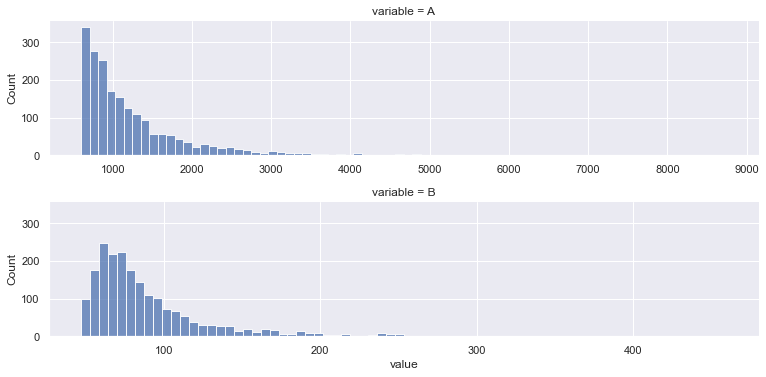

In [20]:
sns.set(rc={'figure.figsize':(16.7, 6.27)})

melted_df = df.melt(id_vars=['Class', 'Case'])
g = sns.FacetGrid(melted_df, row="variable", sharex=False, height=2.7, aspect=4)
g.map_dataframe(sns.histplot, x="value")

We see a right skeweness which can be removed with a transformation. 

We use 1/x transformation to scatter points which are more concentrated near 0 to remove skeweness

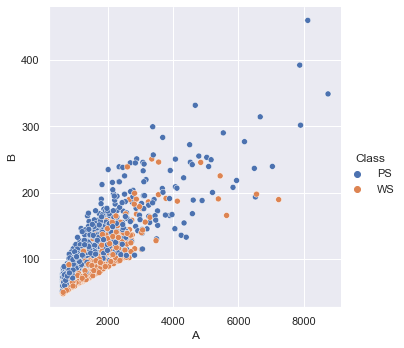

In [21]:
sns.relplot(x=df.A, y=df.B, hue=df.Class);

Next, we'll show how a simple Power Transformer can fix the skeweness of the data.

Estimated lambdas of the box cox transform are: -0.94, -1.16


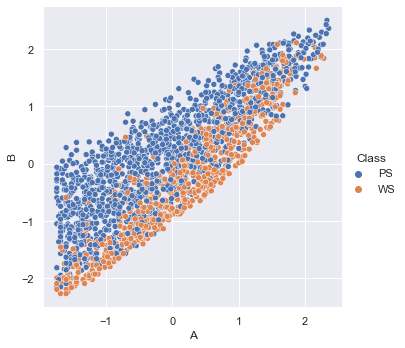

In [22]:
# create a PowerTransformer and fit it on the data
power_transform = PowerTransformer(method='box-cox')
power_transform.fit(df[['A', 'B']])

# print the arguments
lambdas = [str(round(x, 2)) for x in power_transform.lambdas_]
print("Estimated lambdas of the box cox transform are:", ', '.join(lambdas))

inv_features_df = pd.DataFrame(power_transform.transform(df[['A', 'B']]))
inv_features_df.columns = ['A', 'B']
inv_features_df['Class'] = df['Class']

sns.relplot(data=inv_features_df, x='A', y='B', hue='Class');

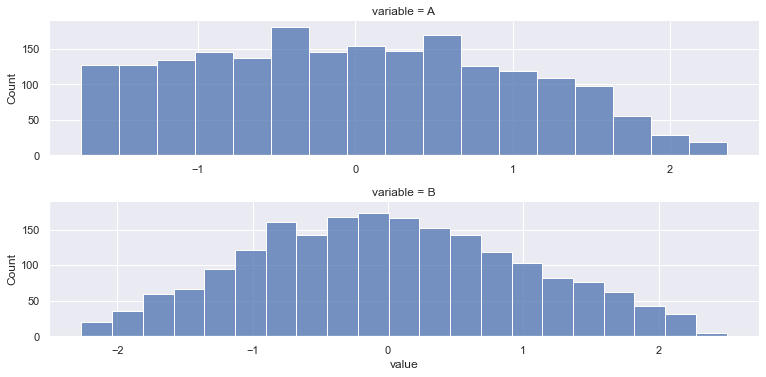

In [23]:
sns.set(rc={'figure.figsize':(16.7, 6.27)})

melted_df = inv_features_df.melt(id_vars=['Class'])
g = sns.FacetGrid(melted_df, row="variable", sharex=False, height=2.7, aspect=4)

g.map_dataframe(sns.histplot, x="value")

We see that after the Box-Cox transformation our data looks a lot more normally distributed.

The Box-Cox Power Transform method assumes normality of the [following transformation](https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation)
and then uses the log likelihood function to find best parameter for $\lambda$ using a scipy optimize method.

## **Modelling**

### **Test set and Train set Data Splitting**

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    df[['A', 'B']], df['Class'], test_size=0.25, random_state=1, stratify=df['Class']
)

X_train.head()

,A,B
77,758.886621,56.527804
377,746.308390,52.680983
185,666.646259,58.224107
1747,930.789116,62.422243
1339,1429.725624,75.453211


### **Fitting the Logistic Regression Model**

In [25]:
le = LabelEncoder()
le.fit(['PS', 'WS']) # encode WS as success
response = le.transform(df['Class']) # encoded classes as 0s, 1s

lr = LogisticRegression(fit_intercept=True, penalty='none')
fit = lr.fit(X_train, y_train)

# print the estimated coefficients of the model
beta0, beta1, beta2 = [round(x, 3) for x in np.append(fit.intercept_, fit.coef_)]

print('The estimated parameters are: ')
display(Math(r'\beta_0 = {}, \beta_1 = {}, \beta_2={} '.format(beta0, beta1, beta2)))

The estimated parameters are: 


<IPython.core.display.Math object>

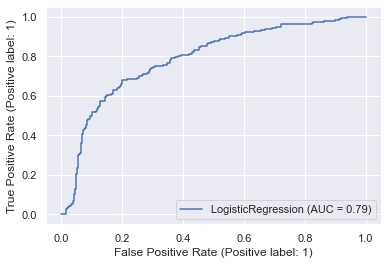

In [89]:
RocCurveDisplay.from_estimator(lr, X_test, y_test)

### **A comparison with a Neural Network**

<AxesSubplot:xlabel='False Positive Rate (Positive label: 1)', ylabel='True Positive Rate (Positive label: 1)'>

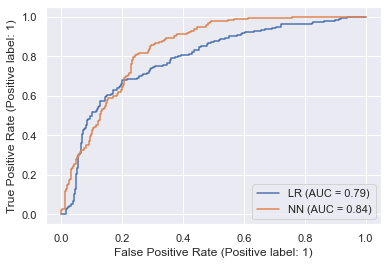

In [90]:
nn = MLPClassifier(hidden_layer_sizes=(12,), random_state=2)
nn.fit(X_train, y_train)

show_auroc_curves([lr, nn], ["LR", "NN"])

<AxesSubplot:xlabel='False Positive Rate (Positive label: WS)', ylabel='True Positive Rate (Positive label: WS)'>

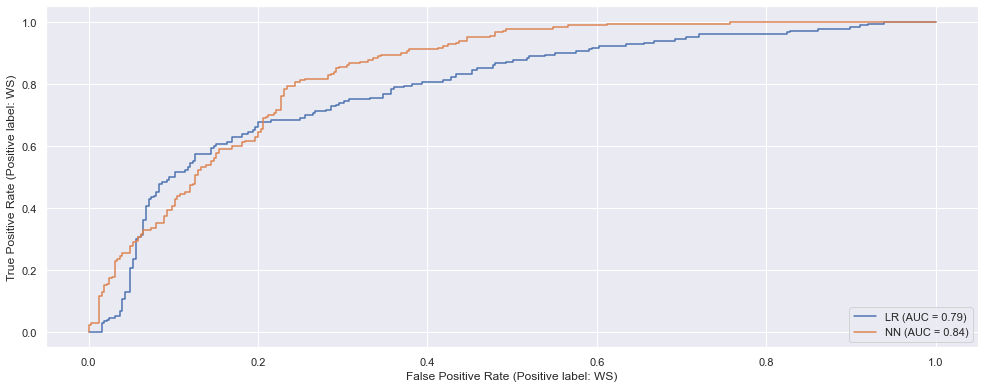

In [28]:
nn = MLPClassifier(hidden_layer_sizes=(12,), random_state=2)
nn.fit(X_train, y_train)

show_auroc_curves([lr, nn], ["LR", "NN"])

We see that there are models performing better than the Logistic Regression. We'll show how a simple transformation on the predictor space can improve the accuracy, while still using a simple model like a Logistic Regression.

### **A Logistic Regresssion with Box-Cox transformation**

In [109]:
from sklearn.preprocessing import StandardScaler

figure(figsize=(8, 6), dpi=80)

y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

pipeline = Pipeline([
    ('box-cox', power_transform),
    ('scaler', StandardScaler()),
    ('regressor', LogisticRegression(fit_intercept=True, penalty='none'))
])

# fit the model and the data
pipeline.fit(X_train, y_train)
tr_features_df = power_transform.fit_transform(X_train)

lr = LogisticRegression(fit_intercept=True, penalty='none')
lr.fit(X_train, y_train)

LogisticRegression(penalty='none')

<Figure size 640x480 with 0 Axes>

<AxesSubplot:xlabel='False Positive Rate (Positive label: 1)', ylabel='True Positive Rate (Positive label: 1)'>

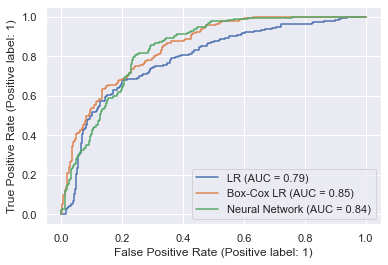

In [93]:


show_auroc_curves([lr, pipeline, nn], ["LR", "Box-Cox LR", "Neural Network"])

We see that, just by applying the Box-Cox transformation, we get a drastic improve in the AUC score and beat the Neural Network model as well.

We look for the up-left most point on the curve.
ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

<br/>

<br >


## **Classification Metrics**

When the outcome is a discrete set of values (i.e., qualitative data), there are two different types of performance metrics that can be utilized. 
* qualitative class prediction (e.g., stem or other) Metrics
* Using the predicted class probabilities to measure model effectiveness (e.g., Pr[stem] = 0.254).

### **Precision and Recall**

#### **Precision**

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

It answers the question, what proportion of the positive identifications were actually correct. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. If we are hyper careful and only predict positive class when we are absolutely sure, we'll have a high precision, because we'll not have many positive predictions, but the ones we'll have will be correct.

<u>Precision is the proportion of events that are predicted correctly out of the total number of predicted events</u>.

In [31]:
from sklearn.metrics import precision_score
# calculate precision by hand

y_pred = pipeline.predict(X_test)

# true positive and false positive proportions
tp = sum(y_pred[y_pred == 1] == y_test[y_pred == 1])
fp = sum(y_pred[y_pred == 1] != y_test[y_pred == 1])

# calculate precision
precision = tp / (tp + fp)

# print results
is_match = precision == precision_score(y_test, y_pred)
print(f"Our calculation do {'' if is_match else 'not'} match with the metric function")
print("The precision equals {:.2f}".format(precision))


Our calculation do  match with the metric function
The precision equals 0.71


#### **Recall**

$$
\text{Recall} = \frac{TP}{TP + FN} = \frac{TP}{\text{All Positive}}
$$

What proportion of the positive class was correctly identified? Or in other words, when the class is positive, how often are we identifying it correctly?

In [32]:
from sklearn.metrics import recall_score

# calculate precision by hand
y_pred = pipeline.predict(X_test)
y_pred = LabelEncoder().fit_transform(y_pred)

# calculate tp and fn
tp = sum(y_pred[y_pred == 1] == y_test[y_pred == 1])
fn = sum(y_pred[y_pred == 0] != y_test[y_pred == 0])

# calculate recall or also called sensitivity
recall = tp / (tp + fn)
recall = tp / sum(y_test)

print(recall)

0.5833333333333334


**Recall** is also called **sensitivity**, and Precision is also known as **positive predictive value**. It is the number of predicted events w.r.t. the total number of events.

If we classify everything as 1, we'll calculate correctly all of the positive class and we'll get a recall of 1.

In [33]:
rec_score = recall_score(y_test, np.repeat(1, y_test.shape[0]))
print(f"Recall is {rec_score}")

Recall is 1.0


But that way, The proportion of correctly identified positive w.r.t. the correct classifications will drop because we are classifying everything as positive, but not everything is positive and we'll have many observations classified as positive while they are in fact negative, i.e. many FN which will increase the denominator.

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

In other words, when we classify as positive, how often are we correct?

In [34]:
precision_score(y_test, np.repeat(1, y_test.shape[0]))

0.3564356435643564

If the cost of a false positive is high, for example we are identifiying whether observed people commited an unforgivable crime and should be executed for it, we want to be sure that we are not sending people to the guillotine for nothing.

In that way, if we are extremelly tolerant, we might classify everyone as non guilty (0s).

In [35]:
y_pred = (pipeline.predict_proba(X_test)[:, 1] > 0.9).astype(int)
precision_score(y_test, y_pred)

1.0

We rarely shoot as positive, but when we do, we are almost always correct (we are precise in our rare predictions for positive). That way, it's very unlikely we'll make false positive prediction since we are doing positive when we are absolutely sure. That way we are going to make a lot of false negative predictions, but if the cost for that is not high, it shouldn't be a problem.

When our precision is high, we'll probably have low recall (sensitivity), since we are making predictions for the positive only when we are sure, we are going to miss a lot of the real positive observations.

In [36]:
y_pred = (pipeline.predict_proba(X_test)[:, 1] > 0.9).astype(int)
recall_score(y_test, y_pred)

0.011111111111111112

### **Precision, Recall (Sensitivity) as conditional statistics**

For example, sensitivity reflects the probability than an event is correctly predicted given that a sample is truly an event.
$$
Recall :=: Sensitivity :=: P(\hat{Y}=1|Y=1) = \frac{P(\hat{Y}=1 \cap Y=1)}{P(Y=1)}
$$

The question that one really wants to know is “if my value was predicted to be an event, what are the chances that it is truly is an event?”
$$
P(Y=1|\hat{Y}=1) = \frac{P(Y=1 \cap \hat{Y}=1)}{P(\hat{Y} = 1)} = \frac{P(\hat{Y}|Y=1)\times P(Y=1)}{P(\hat{Y}=1)} = \frac{\text{likelihood}\times \text{prior}}{\text{evidence}}
$$

* Sensitivity (or specificity, depending on one’s point of view) is the “likelihood” parts of this equation. 
* The prior probability, or prevalence, is the overall rate that we see events in the wild (which may be different from what was observed in our training set).

* For sensitivity, its unconditional analog is called the positive predictive value (PPV)
* The negative predictive value (NPV) is the analog to specificity and can be computed as

$$
NPV := \frac{\text{specificity}\times (1 - \text{prevelance})}{(1-\text{sensitivity})\times prevelance) + \text{specificity}\times (1-prevelance)}
$$

* sensitivity: if the profile is truly STEM, what is the probability that it is correctly predicted?
* PPV: if the profile was predicted as STEM, what is the probability that it is STEM?
* When there is a sufficient amount of data, the prevalence is typically estimated by the proportion of the outcome data that correspond to the event of interest. 

## **Confusion Matrix**

Given a set of predicted classes, the first step in understanding how well the model is working is to create a confusion matrix which is a simple cross-tabulation of the observed and predicted classes. One variant is the following

|  Actual \ <br/> Predicted     |Positive<br>  |  Negative  <br>  |
| :---        |    :----:   |          ---: |
| Positive      | TP       | FP   |
| Negative   | FN        | TN      |

Another variant is

|  Predicted \ <br/> Actual     |Negative<br>  |  Positive  <br>  |
| :---        |    :----:   |          ---: |
| Negative   | TN       | FP   |
| Positive   | FN        | TP      |

The samples that were correctly predicted sit on the diagonal of the table.




In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = pipeline.predict(X_test)

tp = np.count_nonzero((y_pred == 1) & (y_test == 1))
fp = np.count_nonzero((y_pred == 1) & (y_test == 0))

fn = np.count_nonzero((y_pred == 0) & (y_test == 1))
tn = np.count_nonzero((y_pred == 0) & (y_test == 0))

my_conf_matrix = np.array([[tn, fp], [fn, tp]])
my_conf_matrix

array([[282,  43],
       [ 75, 105]])

In [38]:
# or it can be done like that
confusion_matrix(y_test, pipeline.predict(X_test))

array([[282,  43],
       [ 75, 105]])

<Figure size 720x360 with 0 Axes>

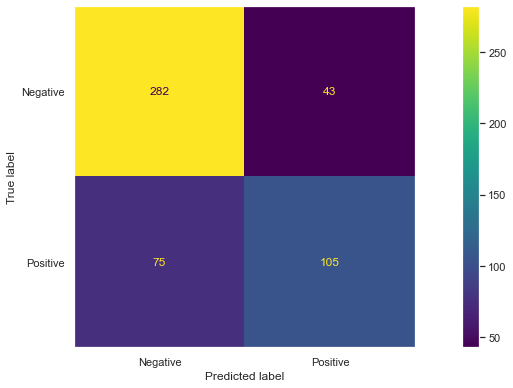

In [39]:
plt.figure(figsize=(10, 5))

ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, display_labels=["Negative", "Positive"])
plt.grid(False)

Another way we can visualize confusion matrices is the following

### **Mosaic Confusion Matrix Plot**

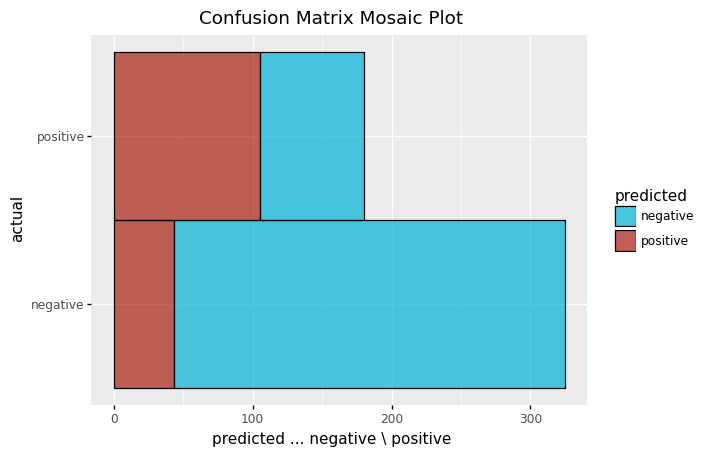

<ggplot: (311831935)>

In [40]:
confusion_df = pd.DataFrame(
    confusion_matrix(y_test, pipeline.predict(X_test)),
    columns=['negative', 'positive'],
    index=['negative', 'positive']
)
# pd.DataFrame({'prediction': ['negative', 'negative', 'positive', 'psotive']})
x = confusion_df.stack().reset_index()
x.columns = ['actual', 'predicted', 'value']

(ggplot(x) +
    aes(x='actual', y='value', fill='predicted') +
    geom_bar(stat='identity', color='#000', width=1, alpha=0.7) +
    ylab('predicted ... negative \\ positive') +
    coord_flip() +
    scale_fill_manual(values=['#00b4d8', '#ae2012']) +
    ggtitle("Confusion Matrix Mosaic Plot")
)

### **Accuracy**

The most widely used classification metric is accuracy which is simply the proportion of correctly identified observations.
$$
Accuracy = \frac{TP + TN}{All}
$$

In [41]:
correct = (y_pred == y_test).sum()
accuracy = correct / len(y_test)
print("Accuracy={:.2f}".format(accuracy))

Accuracy=0.77


There is an implicit tendency to assess model performance by comparing the observed accuracy value to 1/C, where C is the number of classes.
However, this comparison should be made only when there are nearly the same number of samples in each class.

In the above confusion matrix we see that most elements are in the negative class. (**class-imbalance**). Which means that we can generate good accuracy by simply classifying everything as negative.

In [42]:
y_pred_dummy = np.repeat(0, y_test.shape[0])

correct = (y_pred_dummy == y_test).sum()
accuracy = correct / len(y_test)
print("Accuracy={:.2f}".format(accuracy))

Accuracy=0.64


As an alternative to accuracy, another statistic called Cohen’s Kappa (Agresti 2012) can be used to account for class imbalances. 

### **Kohen`s Kappa**

This metric normalizes the error rate to what would be expected by chance. $\kappa \in [-1, 1]$,
$$
\kappa = \frac{2 \times (TP \times TN - FN \times FP)}{(TP + FP) \times (FP + TN) + (TP + FN) \times (FN + TN)}
$$


Kappa takes on values between -1 and 1 where a value of 1 indicates complete concordance between the observed and predicted values (and thus perfect accuracy). A value of -1 is complete discordance and is rarely seen18. Values near zero indicate that there is no relationship between the model predictions and the true results.

### **Sensitivity (Recall) and Specificity**

* **Sensitivity (True Positive Rate)** refers to the proportion of those who received a positive result on this test out of those who actually have the condition (when judged by the ‘Gold Standard’).

$$
\text{Sensitivity} = \frac{TP}{\text{All Positive}}
$$

In [43]:
sensitivity = tp / (y_test == 1).sum()
print("Sensitivity = {:.2f}".format(sensitivity))

Sensitivity = 0.58


* **Specificity (True Negative Rate)** refers to the proportion of those who received a negative result on this test out of those who do not actually have the condition (when judged by the ‘Gold Standard’).

The false positive rate is associated with the specificity, which is,

$$
\text{Specificity} = \frac{TN}{\text{All Negative}}
$$

 <b style="color: #FF2255">**$\text{Fаlse Positive Rate} = 1-\text{Specificity}$**</b>

When we have a highly contagious disease, we want high sensitivity (recall), i.e. to be able to correctly identfy the disease class.
But if we want to correctly identify the people not having the disease, we want high specificity.

## **F1 Score**

Since precision and recall have the same numerator, but different denominators, it only makes sense to use the **harmonic mean** to average them, since it uses the reciprocals.

$$
F_1 = \frac{2}{\text{recall}^{-1} + \text{precision}^{-1}} = 2\frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}
$$

* Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial
* Accuracy can be used when the class distribution is similar while F1-score is a better metric when there are imbalanced classes as in the above case.
* In most real-life classification problems, imbalanced class distribution exists and thus F1-score is a better metric to evaluate our model on.


<br />

The metrics discussed so far depend on having a hard prediction (e.g., STEM or other). Most classification models can produce class probabilities as soft predictions that can be converted to a definitive class by choosing the class with the largest probability. There are a number of metrics that can be created using the probabilities.


## **Receiver operating characteristic**

A ROC curve is a plot of TPR vs FPR, where

$$
TPR = \frac{TP}{P} \\
------------------------- \\
TNR = \frac{TN}{N} \\
------------------------- \\
FPR = 1 - TNR = \frac{FP}{N}
$$


Lets try to generate our own roc curve.


<AxesSubplot:xlabel='fpr', ylabel='tpr'>

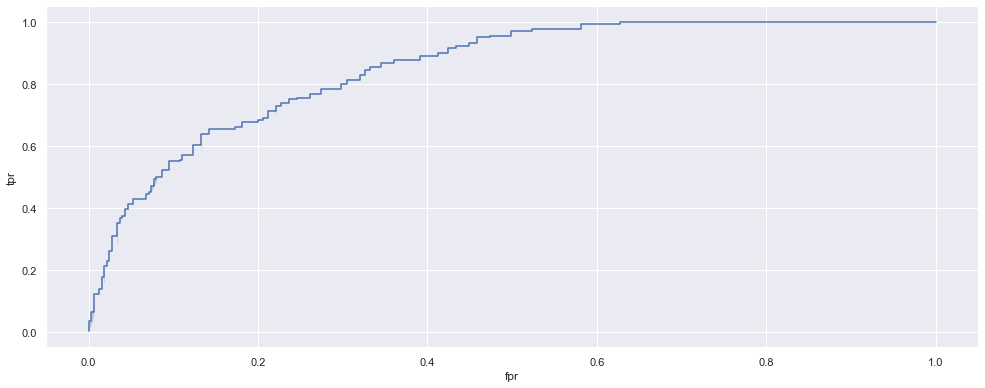

In [44]:
pred_probs = pipeline.predict_proba(X_test)[:,1]
thresholds = np.linspace(0, 1, 100)

def _get_rate(threshold, is_positive):
    """A private method for calculating TPR and TNR"""
    y_pred = (pred_probs > threshold).astype(int)
    rate = int(is_positive)
    correct = ((y_pred == rate) & (y_test == rate)).sum()
    actual = (y_test == rate).sum()
    return correct / actual

def get_tpr(threshold):
    return _get_rate(threshold, True)

def get_fpr(threshold):
    return 1 - _get_rate(threshold, False)

roc_df = pd.DataFrame({
    'tpr': [get_tpr(th) for th in thresholds],
    'fpr': [get_fpr(th) for th in thresholds]
})

sns.lineplot(x='fpr', y='tpr', data=roc_df, drawstyle='steps-pre')

The ROC curve is a plot of the Sensitivity (Recall) vs 1 - Specificity. In other words, <u>how does our Sensitivity increase, when our specificity decreases</u>.

A false positive in this case occurs when the person tests positive, but does not actually have the disease.

**ROC curve** is an alternative to a tons of Confusion Matrices. They also help us decide the best threshold to use so that we make as little type 1 and type 2 errors.

### **Binomial log-likelihood statistic**

we will use  $y_{ij}$ to represent the indicator of the true class of the $i^{th}$ sample. That is, $y_{ij} = 1$ if $i^{th}$ observation equals the $j^{th}$ class. $p_{ij}$ is the predicted probability of ith observation being in the jth class.

$$
\log{l} := \log{\prod_{i=1}^n{\sum_{j=1}^C{p_{ij}^{y_{ij}}}}} = \sum_{i=1}^n\sum_{j=1}^C{y_{ij}\log{p_{ij}}}
$$

In general, we want to maximize the log-likelihood (**MLE**). This value will be maximized if all samples are predicted with high probability to be in the correct class.

### **Gini criterion (Breiman et al. 1984)**

The **gini criterion** measures uncertainty, variance or impurity. It equals the probability of taking any observation and misclassifying it with another class. We want to minimize it.

$$
G := \sum_{i=1}^n\sum_{j \neq j'}{p_{ij}}
$$

### **Entropy**

Lets first define Surprise S as

$$
S(X) = \frac{1}{p(x)}
$$

If X is a random variable:

$$
\text{Entropy} := E(log(S(X))) = \sum_{x}{p(x)\log({p(x)^{-1})}} = -\sum_{x}{p(x)\log{p(x)}}
$$

In our case if we average over all observation and classes

$$
H = -\sum_{i=1}^n\sum_{j=1}^C{p_{ij}\log_2{p_{ij}}}
$$

This metric is also something we are looking to minimize.

/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 25'. Pick better value with 'binwidth'.


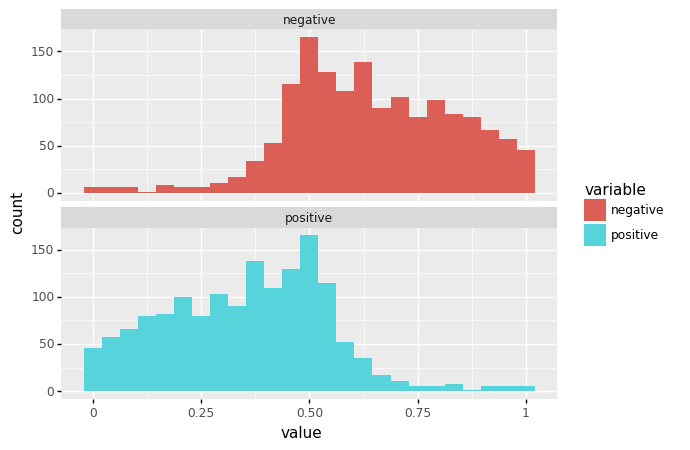

<ggplot: (311906512)>

In [45]:
pred_probs_df = pd.DataFrame(lr.predict_proba(X_train), columns=['negative', 'positive'])

(ggplot(pred_probs_df.melt()) +
    aes(x='value', fill='variable') +
    geom_histogram() +
    facet_wrap('variable',nrow=2)
)

### **Recall-Precision Curve**

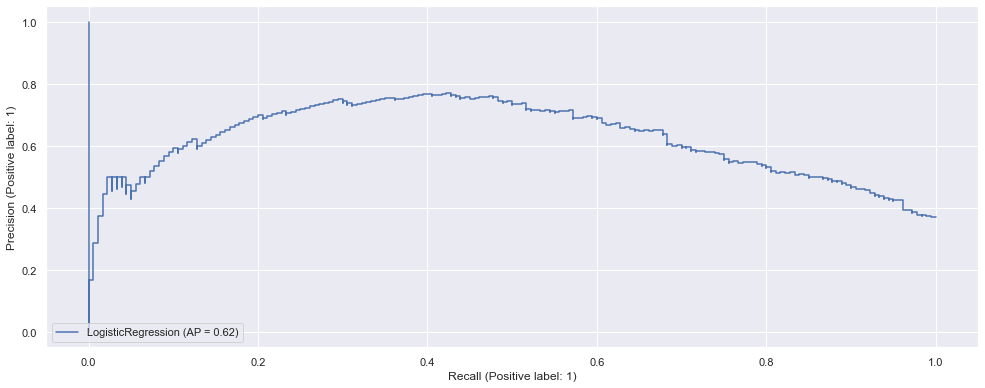

In [46]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(lr, X_test, y_test)

### **Comparing many models**

In [120]:
from sklearn.model_selection import RepeatedKFold, train_test_split, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score

[lr, nn, pipeline]

rkf = RepeatedKFold(n_splits=5, n_repeats=10)

# X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.10)

# knn_clf = KNeighborsClassifier(n_neighbors= 13, weights='distance', metric='minkowski')
scoring = make_scorer(roc_auc_score, needs_proba=False, multi_class="ovr")

lr_scores = cross_val_score(lr, X_train, y_train, scoring=scoring, cv=rkf)
nn_scores = cross_val_score(nn, X_train, y_train, scoring=scoring, cv=rkf)
lrbc_scores = cross_val_score(pipeline, X_train, y_train, scoring=scoring, cv=rkf)

nn_df = pd.DataFrame({'score': nn_scores, 'model': 'NN'})
lr_df = pd.DataFrame({'score': lr_scores, 'model': 'LR'})
lrbc_df = pd.DataFrame({'score': lrbc_scores, 'model': 'LR + Box-Cox'})

# nn_scores

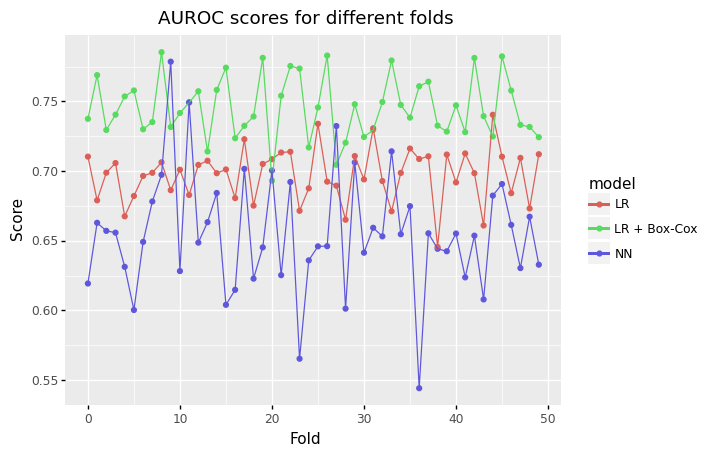

<ggplot: (311992667)>

In [123]:
results_df = pd.concat([lrbc_df, nn_df, lr_df]).reset_index()
(ggplot(results_df) +
    aes(x='index', y='score', color='model') +
    geom_point() + geom_line() +
    ggtitle("AUROC scores for different folds") +
    xlab("Fold") + ylab("Score")
)

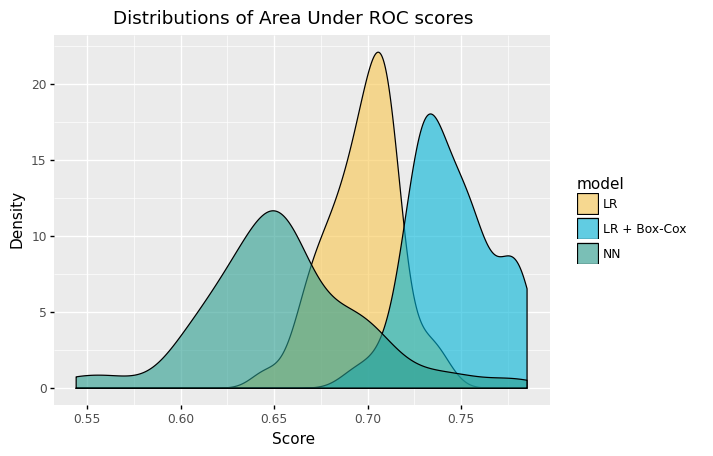

<ggplot: (313571874)>

In [132]:
(ggplot(results_df) +
    aes(x='score', fill='model') +
    geom_density(alpha=0.6) +
    scale_fill_manual(values=['#f9c74f', '#00b4d8', '#2a9d8f']) +
    ggtitle("Distributions of Area Under ROC scores") +
    xlab("Score") + ylab("Density")
)

In [134]:
from scipy.stats import ttest_ind
print("Mean Difference is {:.2f}".format((lrbc_scores - lr_scores).mean()))

ttest_ind(lrbc_scores, lr_scores, alternative='greater')

Mean Difference is 0.05


Ttest_indResult(statistic=11.588287449270466, pvalue=2.2635883836873926e-20)